https://www.tensorflow.org/tutorials/audio/simple_audio

In [1]:
import os
import pickle
import pathlib

import matplotlib.pyplot as plt
import glob
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [2]:
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
# data_dir = pathlib.Path('data/mini_speech_commands')
# if not data_dir.exists():
#   tf.keras.utils.get_file(
#       'mini_speech_commands.zip',
#       origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
#       extract=True,
#       cache_dir='.', cache_subdir='data')

In [ ]:
data_dir = "../frequent_words/en/clips/"
#commands = np.array(tf.io.gfile.listdir(str(data_dir)))
#commands = commands[commands != 'README.md']
print('Commands:', commands)

In [9]:
cs = np.random.choice(commands, 100)
print(cs)

['between' 'began' 'eight' 'thing' 'university' 'made' 'need' 'always'
 'public' 'small' 'decided' 'told' 'now' 'based' 'again' 'six' 'team'
 'back' 'album' 'see' 'found' 'live' 'without' 'family' 'here' 'nothing'
 'heard' 'wanted' 'mean' 'called' 'things' 'made' 'saw' 'local' 'just'
 'green' 'after' 'little' 'state' 'go' 'give' 'get' 'green' 'up' 'county'
 'after' 'state' 'friend' 'looked' 'college' 'use' 'school' 'only' 'them'
 'four' 'help' 'took' 'war' 'city' 'must' 'east' 'desert' 'decided' 'last'
 'party' 'early' 'red' 'called' 'once' 'think' 'without' 'company' 'find'
 'might' 'better' 'nothing' 'part' 'place' 'school' 'three' 'things'
 'where' 'wind' 'men' 'such' 'them' 'woman' 'game' 'asked' 'off' 'years'
 'five' 'everything' 'located' 'really' 'englishman' 'become' 'left'
 'station' 'young']


In [3]:
os.chdir("../train_100/")

In [12]:
raise ValueError("caution: overwrites current training list")
with open("wordlist.txt", 'w') as fh:
    for c in cs:
        fh.write(f"{c}\n")

In [4]:
with open("wordlist.txt", "r") as fh:
    wordlist = fh.read().splitlines()

In [5]:
len(wordlist)

100

In [126]:
" ".join(wordlist)

'between began eight thing university made need always public small decided told now based again six team back album see found live without family here nothing heard wanted mean called things made saw local just green after little state go give get green up county after state friend looked college use school only them four help took war city must east desert decided last party early red called once think without company find might better nothing part place school three things where wind men such them woman game asked off years five everything located really englishman become left station young'

In [6]:
commands = np.array(wordlist)

In [102]:
np.argmax("young" == commands)

99

In [7]:
data_dir="/home/mark/tinyspeech_harvard/frequent_words/en/clips/"

In [ ]:
raise ValueError("caution: overwrites current training list")
dataset = {}
for c in cs:
    wavs = glob.glob(data_dir + c + "/*.wav")
    dataset[c] = np.random.choice(wavs, 2000, replace=False)
with open('dataset.pkl', 'wb') as fh:
    pickle.dump(dataset, fh, pickle.HIGHEST_PROTOCOL)

In [8]:
with open('dataset.pkl', 'rb') as fh:
    dataset = pickle.load(fh)

In [9]:
dataset['party'][:10]

array(['/home/mark/tinyspeech_harvard/frequent_words/en/clips/party/common_voice_en_20791358.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/party/common_voice_en_686391.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/party/common_voice_en_17885108.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/party/common_voice_en_20827593.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/party/common_voice_en_17883618.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/party/common_voice_en_19093350.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/party/common_voice_en_21380127.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/party/common_voice_en_20725173__2.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/party/common_voice_en_18944402.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/party/common_voice_en_21622544.wav'],
      dt

In [10]:
for k, vs in dataset.items():
    if len(vs) != 2000:
        raise ValueError("ruh roh")

In [11]:
filenames = []
for _, vs in dataset.items():
    #filenames.extend(vs)
    filenames.extend(map(str,vs))
    #filenames.extend(list(map(tf.io.gfile.GFile,vs)))

Extract the audio files into a list and shuffle the list.

In [12]:
#filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
#print('Number of examples per label:',
#      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 178000
Example file tensor: tf.Tensor(b'/home/mark/tinyspeech_harvard/frequent_words/en/clips/better/common_voice_en_16396949.wav', shape=(), dtype=string)


Split the files into training, validation and test sets using a 80:10:10 ratio respectively.

In [41]:
178000*.8

142400.0

In [59]:
142400 + 17800 + 17800

178000

In [13]:
train_files = filenames[:142400]
val_files = filenames[142400: 142400 + 17800]
test_files = filenames[-17800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 142400
Validation set size 17800
Test set size 17800


In [71]:
vfs = set([v.numpy() for v in val_files])
zfs = set([v.numpy() for v in test_files])
tfs = set([v.numpy() for v in train_files])

In [76]:
izn = tfs.intersection(vfs)
len(izn)
#print(list(izn)[0])

0

## Reading audio files and their labels

In [14]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

The label for the wav file is its parent directory.

In [15]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2] 

Let's define a method that will take in the filename of the wav file and output an audio, label tuple for supervised training.

In [16]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

You will now apply `process_path` to build our training set to extract audio, label pairs and check the results. You'll build the validation and test sets using a similar procedure later on.

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

Let's examine a few audio waveforms with their corresponding labels.

tf.Tensor(74, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(90, shape=(), dtype=int64)
tf.Tensor(82, shape=(), dtype=int64)
tf.Tensor(22, shape=(), dtype=int64)
tf.Tensor(51, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(39, shape=(), dtype=int64)
tf.Tensor(22, shape=(), dtype=int64)


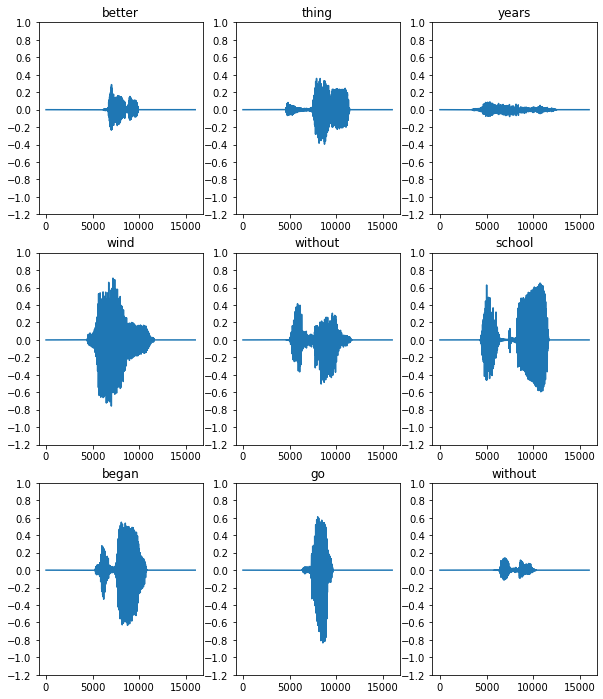

In [18]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  lc = label == commands
  print(tf.argmax(tf.dtypes.cast(lc, tf.int32)))
  label = label.numpy().decode('utf-8')
  
  ax.set_title(label)

plt.show()

## Spectrogram

You'll convert the waveform into a spectrogram, which shows frequency changes over time and can be represented as a 2D image. This can be done by applying short time fourier transform (STFT) to convert the audio into the time-frequency domain.

A fourier transform ([`tf.signal.fft`](https://www.tensorflow.org/api_docs/python/tf/signal/fft)) converts a signal to its component frequencies, but looses all time information. The STFT ([`tf.signal.stft`](https://www.tensorflow.org/api_docs/python/tf/signal/stft)) splits the signal into windows of time and runs a fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

STFT produces an array of complex numbers representing magnitude and phase. However, you'll only need the magnitude for this tutorial, which can be derived by applying `tf.abs` on the output of `tf.signal.stft`. 

Choose `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more info on STFT parameters choice, you can refer to [this video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe). 

You also want to waveforms to have the same length so that when you convert it to a spectrogram image, the results will have similar dimensions. This can be done by simply zero padding the audio clips that are shorter than one second.



In [19]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
      
  spectrogram = tf.abs(spectrogram)

  return spectrogram

Next, you will explore the data. Compare the waveform, the spectrogram and the actual audio of one example from the dataset.

In [20]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: better
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


/home/mark/miniconda3/envs/tinyspeech/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/mark/miniconda3/envs/tinyspeech/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


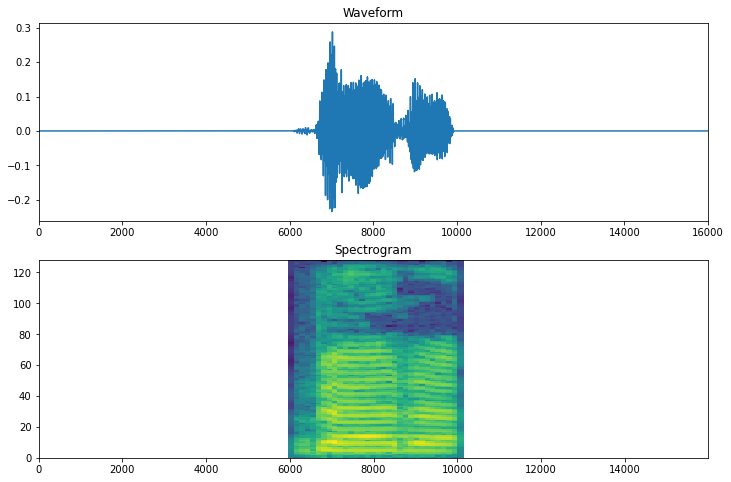

In [21]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  X = np.arange(16000, step=height + 1)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Now transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs.

In [22]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  lc = label == commands
  lc = tf.dtypes.cast(lc, tf.int32) #https://github.com/tensorflow/tensorflow/issues/33685
  label_id = tf.argmax(lc)
  return spectrogram, label_id

In [23]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

Examine the spectrogram "images" for different samples of the dataset.

/home/mark/miniconda3/envs/tinyspeech/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/mark/miniconda3/envs/tinyspeech/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


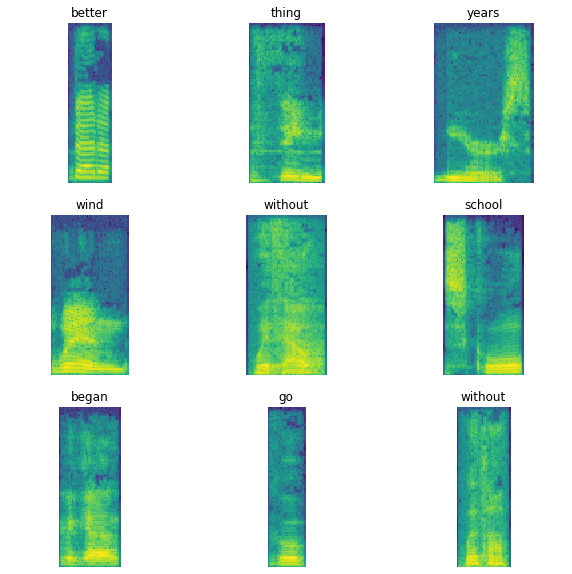

In [24]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')
  
plt.show()

## Build and train the model

Before you build and train our model, you would need apply the same data processing done on the training set with the validation and test sets.

In [25]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [26]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Batch the training and validation sets for model training.

In [27]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add dataset [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) operations to reduce read latency while training the model.

In [28]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.
The model also has the following additional preprocessing layers:
- A [`Resizing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer to downsample the input to enable the model to train faster.
- A [`Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization) layer to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (i.e. mean and standard deviation).

In [30]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    #preprocessing.Resizing(64,64), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    #layers.Dense(1200, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            

In [31]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [32]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
2225/2225 [==============================] - 48s 22ms/step - loss: 2.1909 - accuracy: 0.4247 - val_loss: 1.1730 - val_accuracy: 0.6916
Epoch 2/10
2225/2225 [==============================] - 11s 5ms/step - loss: 1.5092 - accuracy: 0.5799 - val_loss: 0.9791 - val_accuracy: 0.7337
Epoch 3/10
2225/2225 [==============================] - 11s 5ms/step - loss: 1.3524 - accuracy: 0.6205 - val_loss: 0.9044 - val_accuracy: 0.7601
Epoch 4/10
2225/2225 [==============================] - 11s 5ms/step - loss: 1.2589 - accuracy: 0.6429 - val_loss: 0.8426 - val_accuracy: 0.7690
Epoch 5/10
2225/2225 [==============================] - 11s 5ms/step - loss: 1.1964 - accuracy: 0.6592 - val_loss: 0.8029 - val_accuracy: 0.7797
Epoch 6/10
2225/2225 [==============================] - 11s 5ms/step - loss: 1.1414 - accuracy: 0.6742 - val_loss: 0.7755 - val_accuracy: 0.7857
Epoch 7/10
2225/2225 [==============================] - 11s 5ms/step - loss: 1.1034 - accuracy: 0.6843 - val_loss: 0.7612 - val_a

Let's check the training and validation loss curves to see how our model has improved during training.

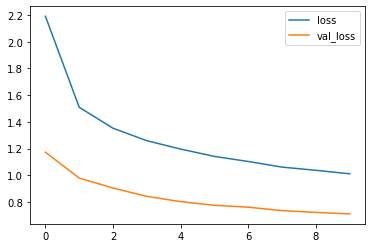

In [33]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [34]:
model.save("hundred_word")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: hundred_word/assets


In [29]:
model = tf.keras.models.load_model("hundred_word")

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

## Evaluate test set performance

Let's run the model on the test set and check performance.

In [ ]:
WHY DOES THIS CRASH???

test_audio = []
test_labels = []

for ix,(audio, label) in enumerate(test_ds):
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())
  if ix % 2000 == 0:
    print(ix)
  #if ix > 16000:
  #  break

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [31]:
test_audio = []
test_labels = []

for ix,(audio, label) in enumerate(test_ds):
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())
  if ix % 2000 == 0:
    print(ix)
  if ix > 16000:
    break

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

0
2000
4000
6000
8000
10000
12000
14000
16000


In [32]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 80%


### Display a confusion matrix

A confusion matrix is helpful to see how well the model did on each of the commands in the test set.

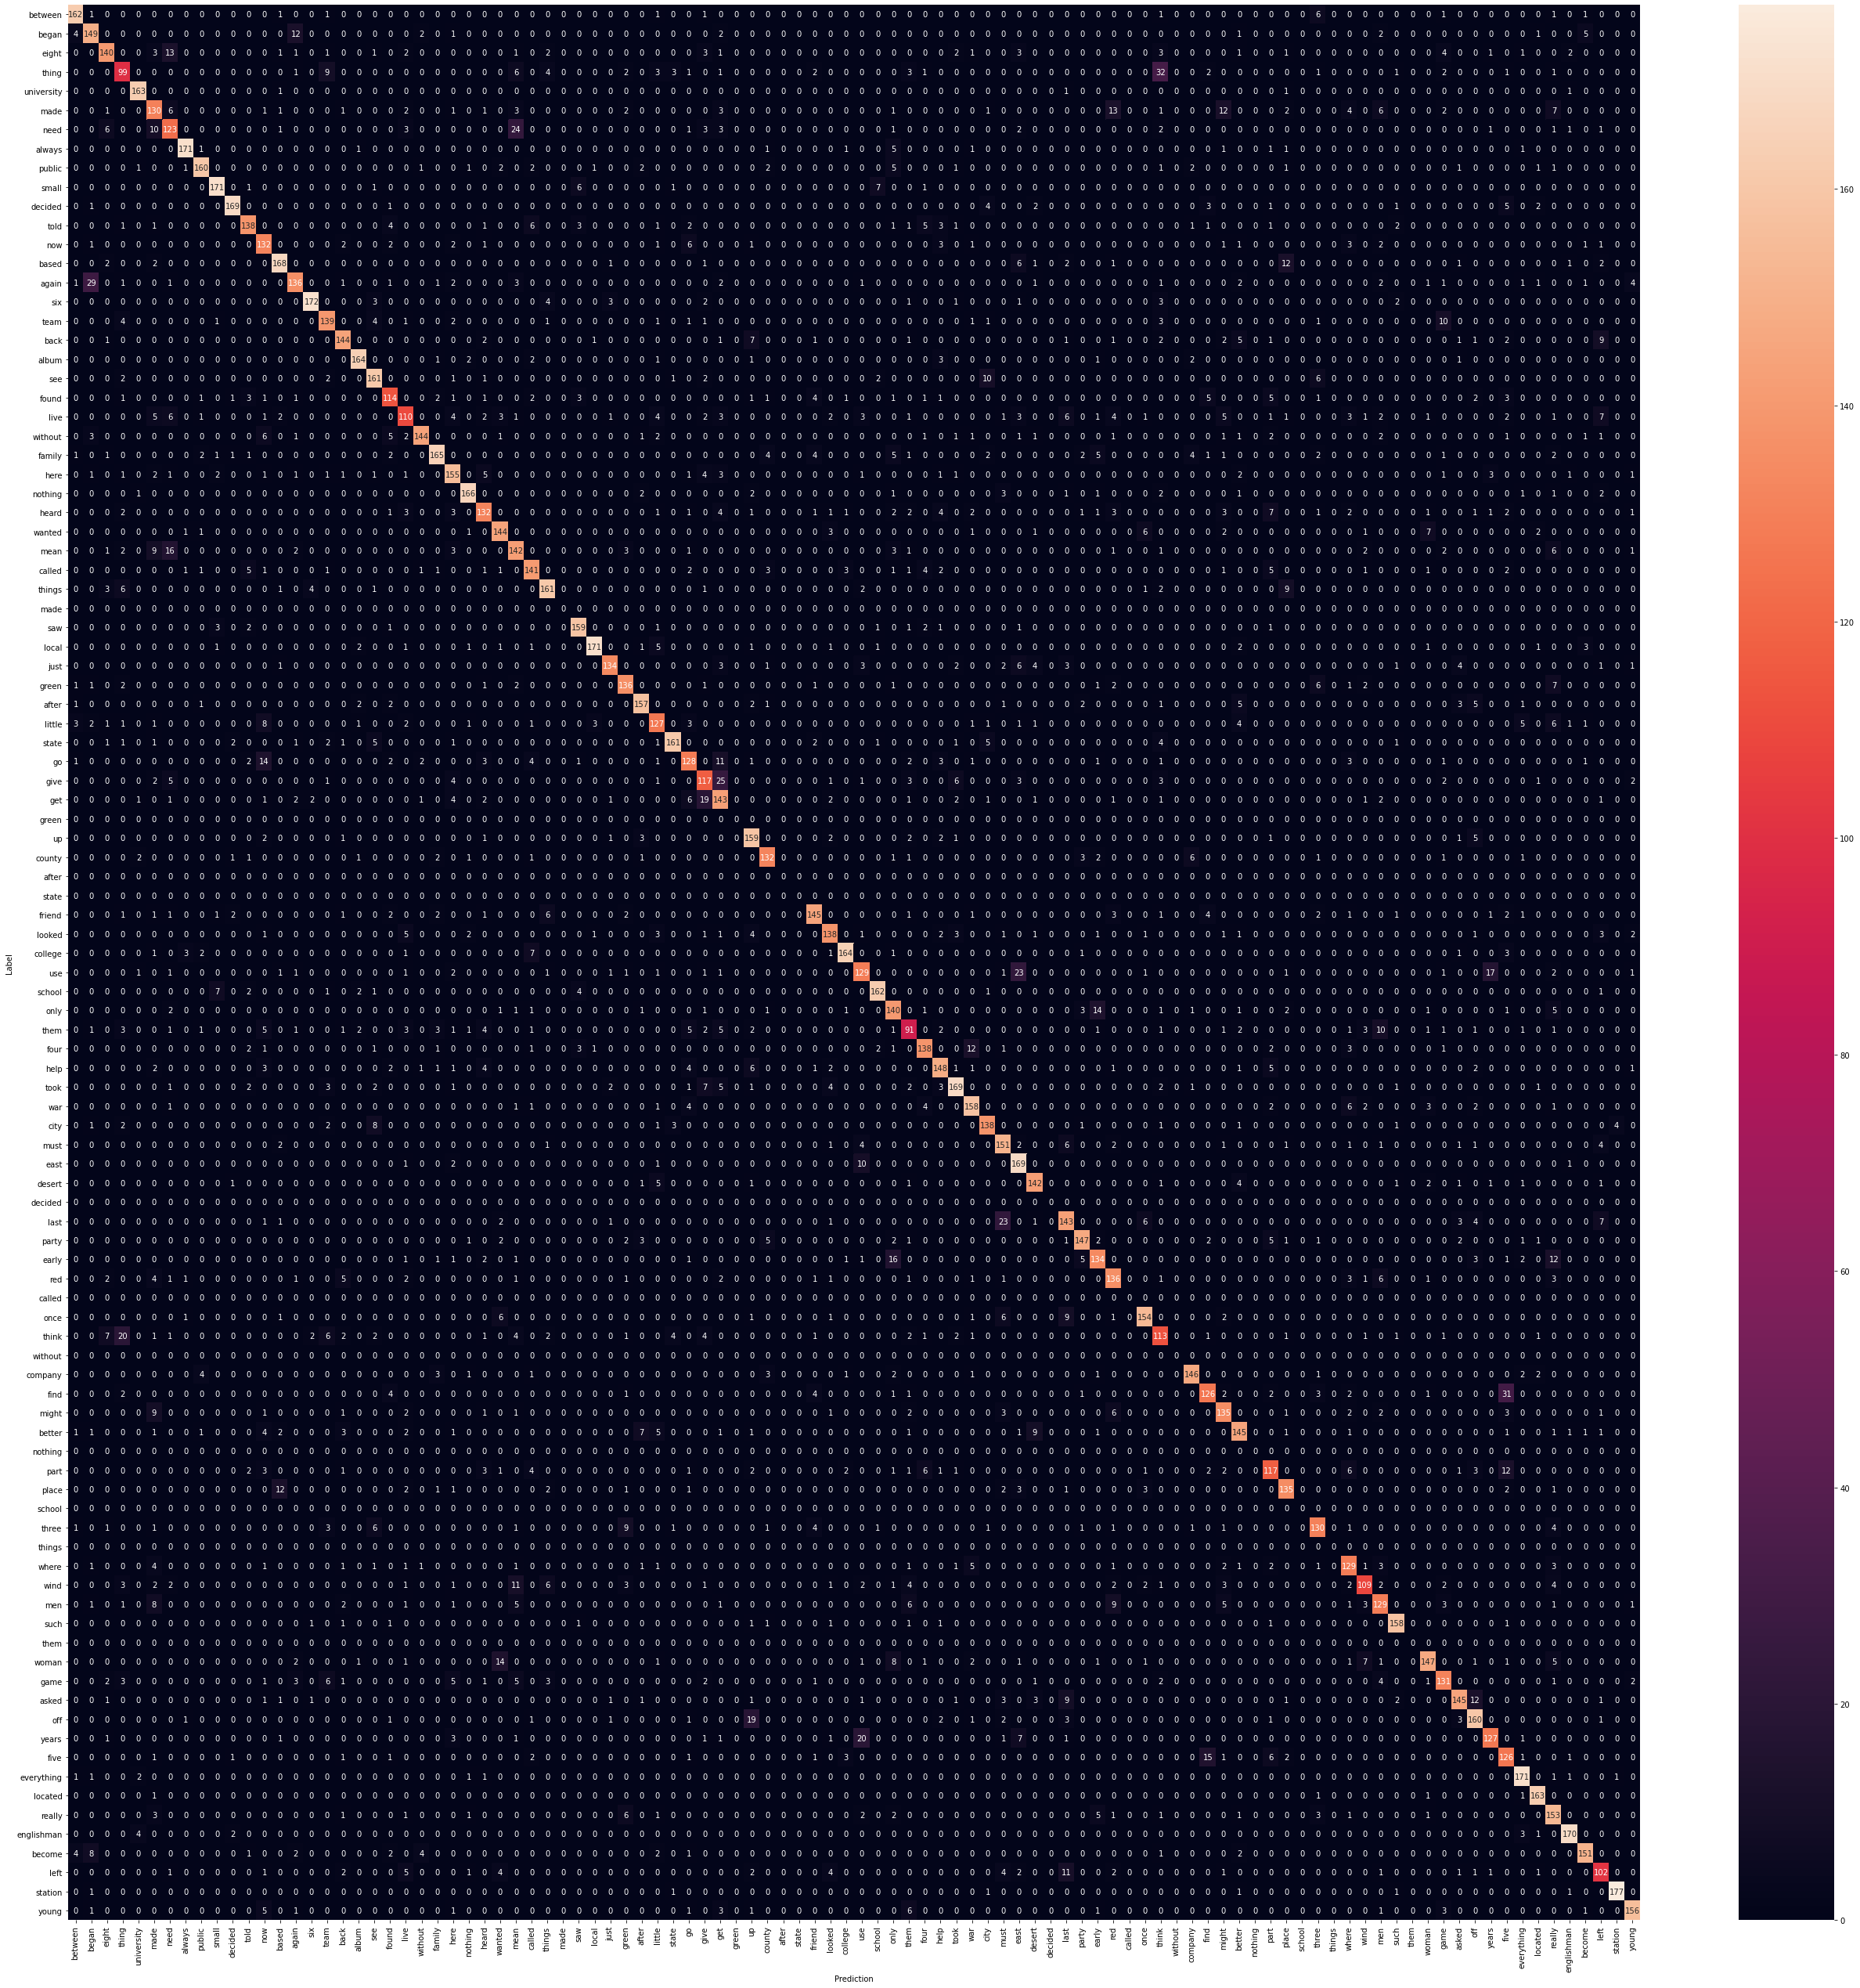

In [34]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.gcf().set_size_inches(45,45)

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no." How well does our model perform?

In [36]:
f = np.random.choice(filenames,1)[0]
print(f)

b'/home/mark/tinyspeech_harvard/frequent_words/en/clips/back/common_voice_en_656677.wav'


In [39]:
os.path.exists(f)

True

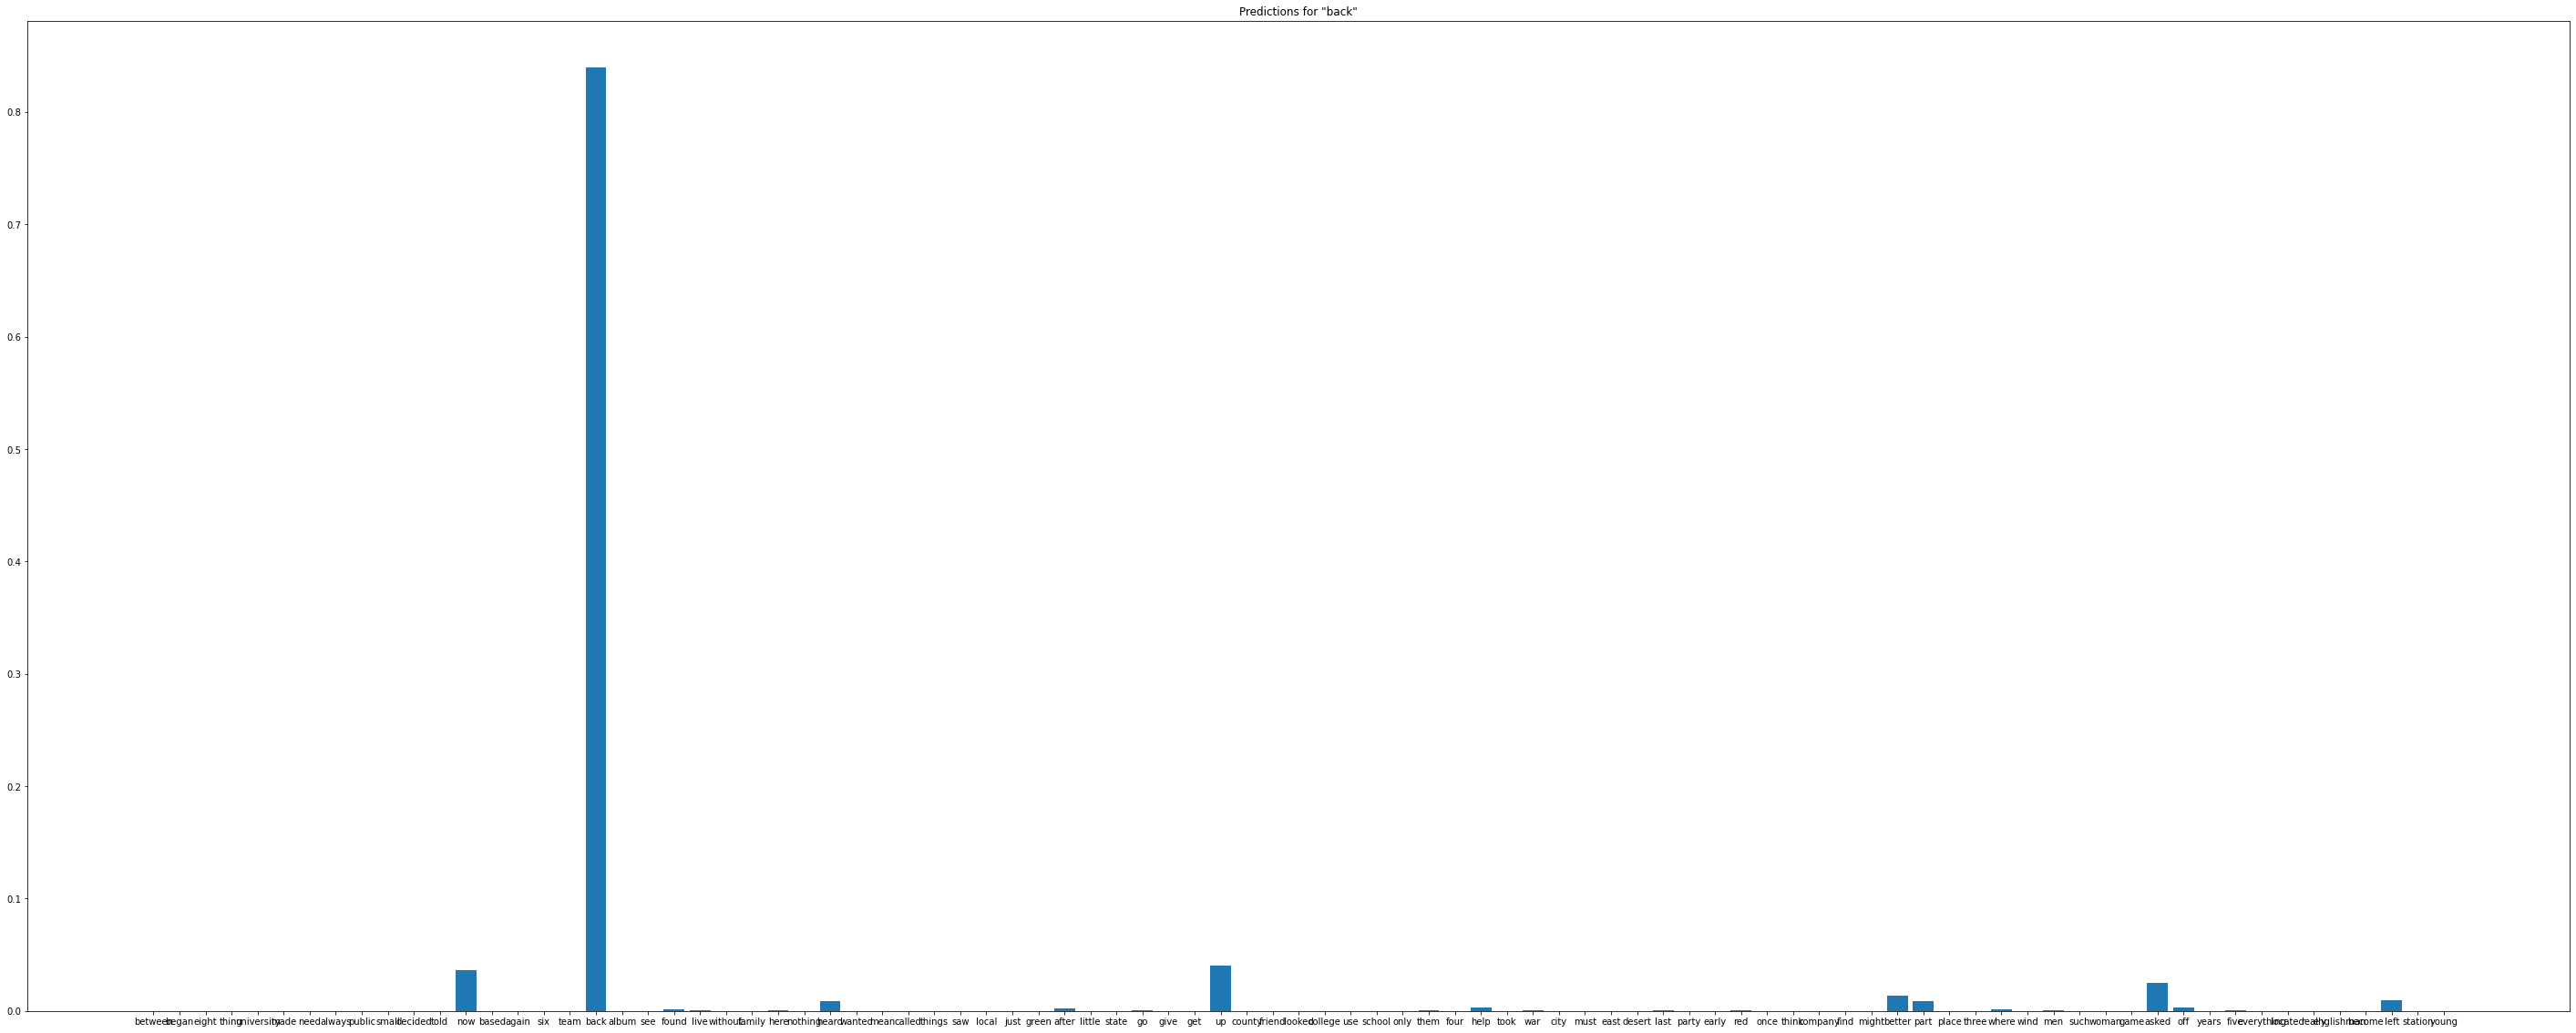

In [41]:
#sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([f])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.gcf().set_size_inches(50,20)

Next steps

This tutorial showed how you could do simple audio classification using a convolutional neural network with TensorFlow and Python.

* To learn how to use transfer learning for audio classification, check out the [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial.

* To build your own interactive web app for audio classification, consider taking the [TensorFlow.js - Audio recognition using transfer learning codelab](https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0).

* TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.



# Embeddings

In [42]:
# https://keras.io/guides/sequential_model/
print(len(model.layers))

10


In [43]:
model.pop()

In [44]:
print(len(model.layers))

9


In [45]:
commands

array(['between', 'began', 'eight', 'thing', 'university', 'made', 'need',
       'always', 'public', 'small', 'decided', 'told', 'now', 'based',
       'again', 'six', 'team', 'back', 'album', 'see', 'found', 'live',
       'without', 'family', 'here', 'nothing', 'heard', 'wanted', 'mean',
       'called', 'things', 'made', 'saw', 'local', 'just', 'green',
       'after', 'little', 'state', 'go', 'give', 'get', 'green', 'up',
       'county', 'after', 'state', 'friend', 'looked', 'college', 'use',
       'school', 'only', 'them', 'four', 'help', 'took', 'war', 'city',
       'must', 'east', 'desert', 'decided', 'last', 'party', 'early',
       'red', 'called', 'once', 'think', 'without', 'company', 'find',
       'might', 'better', 'nothing', 'part', 'place', 'school', 'three',
       'things', 'where', 'wind', 'men', 'such', 'them', 'woman', 'game',
       'asked', 'off', 'years', 'five', 'everything', 'located', 'really',
       'englishman', 'become', 'left', 'station', 'young'], d

In [49]:
cset = set(commands)
all_words = os.listdir(data_dir)
other_words = []
for w in all_words:
    if w not in cset and w != "_background_noise_":
        other_words.append(w)
print(len(other_words))

176


In [52]:
" ".join(other_words)

'went love those every still man house light first group heart through other used sheep looking good blue point main both night long father written going under mind people children during second served would something next put please sound very continued river day old set boy park large son should ever want away who few also girl include different around some never named time these read than north gold then sun air times answered everyone being became will number hand today office seen born before area well anything known lot own film building many book earth west does way show take high morning look several district even end because one nine much later could year united more name since street great most days done alchemist life say eyes over black road work same know each best how language water music built often system appeared about right been money played when knew make tell idea playing thought south play down like near fire however town into matter king which already seven anothe

In [94]:
NUM_EXAMPLES = 150
otherword_examples = {}
for w in other_words:
    wavs = glob.glob(data_dir + w + "/*.wav")
    otherword_examples[w] = np.random.choice(wavs, NUM_EXAMPLES, replace=False)
#print(otherword_examples)

In [95]:
otherword_examples["language"][:5]

array(['/home/mark/tinyspeech_harvard/frequent_words/en/clips/language/common_voice_en_22341510__2.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/language/common_voice_en_601016.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/language/common_voice_en_644323.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/language/common_voice_en_158331.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/language/common_voice_en_504501.wav'],
      dtype='<U94')

In [64]:
def get_spectrogram_and_label(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  return spectrogram, label
def preprocess_nondataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(get_spectrogram_and_label, num_parallel_calls=AUTOTUNE)
  return output_ds

In [101]:
otherword_files = [file for files in otherword_examples.values() for file in files]

In [105]:
for k, v in embeddings.items():
    print(k, len(v))

went 150
love 150
those 150
every 150
still 150
man 150
house 150
light 150
first 150
group 150
heart 150
through 150
other 150
used 150
sheep 150
looking 150
good 150
blue 150
point 150
main 150
both 150
night 150
long 150
father 150
written 150
going 150
under 150
mind 150
people 150
children 150
during 150
second 150
served 150
would 150
something 150
next 150
put 150
please 150
sound 150
very 150
continued 150
river 150
day 150
old 150
set 150
boy 150
park 150
large 150
son 150
should 150
ever 150
want 150
away 150
who 150
few 150
also 150
girl 150
include 150
different 150
around 150
some 150
never 150
named 150
time 150
these 150
read 150
than 150
north 150
gold 150
then 150
sun 150
air 150
times 150
answered 150
everyone 150
being 150
became 150
will 150
number 150
hand 150
today 150
office 150
seen 150
born 150
before 150
area 150
well 150
anything 150
known 150
lot 150
own 150
film 150
building 150
many 150
book 150
earth 150
west 150
does 150
way 150
show 150
take 150
high 15

In [102]:
sample_ds = preprocess_nondataset(otherword_files)

embeddings = {w:[] for w in other_words}

for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram)
    label = label[0].numpy().decode("utf8")
    embeddings[label].append(prediction[0].numpy())

InvalidArgumentError: Can not squeeze dim[1], expected a dimension of 1, got 2
	 [[{{node Squeeze}}]]

In [106]:
good_embeddings = {}
for k,v in embeddings.items():
    if len(v) == 150:
        good_embeddings[k] = v

In [123]:
len(good_embeddings.keys())

149

In [124]:
" ".join(good_embeddings.keys())

'went love those every still man house light first group heart through other used sheep looking good blue point main both night long father written going under mind people children during second served would something next put please sound very continued river day old set boy park large son should ever want away who few also girl include different around some never named time these read than north gold then sun air times answered everyone being became will number hand today office seen born before area well anything known lot own film building many book earth west does way show take high morning look several district even end because one nine much later could year united more name since street great most days done alchemist life say eyes over black road work same know each best how language water music built often system appeared about right been money played'

In [107]:
rawdata = [embedding for key, embeddings in good_embeddings.items() for embedding in embeddings]
len(rawdata)

22350

In [109]:
rawdata = np.array(rawdata)

In [110]:
rawdata.shape

(22350, 128)

In [75]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd

In [74]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30., n_iter=1000)

In [111]:
# htgood_embeddingsowardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
# https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
fit = tsne.fit_transform(rawdata)
fit.shape

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 22350 samples in 0.289s...
[t-SNE] Computed neighbors for 22350 samples in 103.001s...
[t-SNE] Computed conditional probabilities for sample 1000 / 22350
[t-SNE] Computed conditional probabilities for sample 2000 / 22350
[t-SNE] Computed conditional probabilities for sample 3000 / 22350
[t-SNE] Computed conditional probabilities for sample 4000 / 22350
[t-SNE] Computed conditional probabilities for sample 5000 / 22350
[t-SNE] Computed conditional probabilities for sample 6000 / 22350
[t-SNE] Computed conditional probabilities for sample 7000 / 22350
[t-SNE] Computed conditional probabilities for sample 8000 / 22350
[t-SNE] Computed conditional probabilities for sample 9000 / 22350
[t-SNE] Computed conditional probabilities for sample 10000 / 22350
[t-SNE] Computed conditional probabilities for sample 11000 / 22350
[t-SNE] Computed conditional probabilities for sample 12000 / 22350
[t-SNE] Computed conditional probabilities for s

(22350, 2)

In [114]:
matched_keys = [key for key, embeddings in good_embeddings.items() for embedding in embeddings]
print(len(matched_keys))
matched_keys[0:5]

22350


['went', 'went', 'went', 'went', 'went']

In [115]:
df = pd.DataFrame({"x":fit[:,0], "y":fit[:,1],"keyword":matched_keys})

In [120]:
os.getcwd()

'/home/mark/tinyspeech_harvard/train_100'

In [122]:
df.to_csv("tsne.csv", index=False)

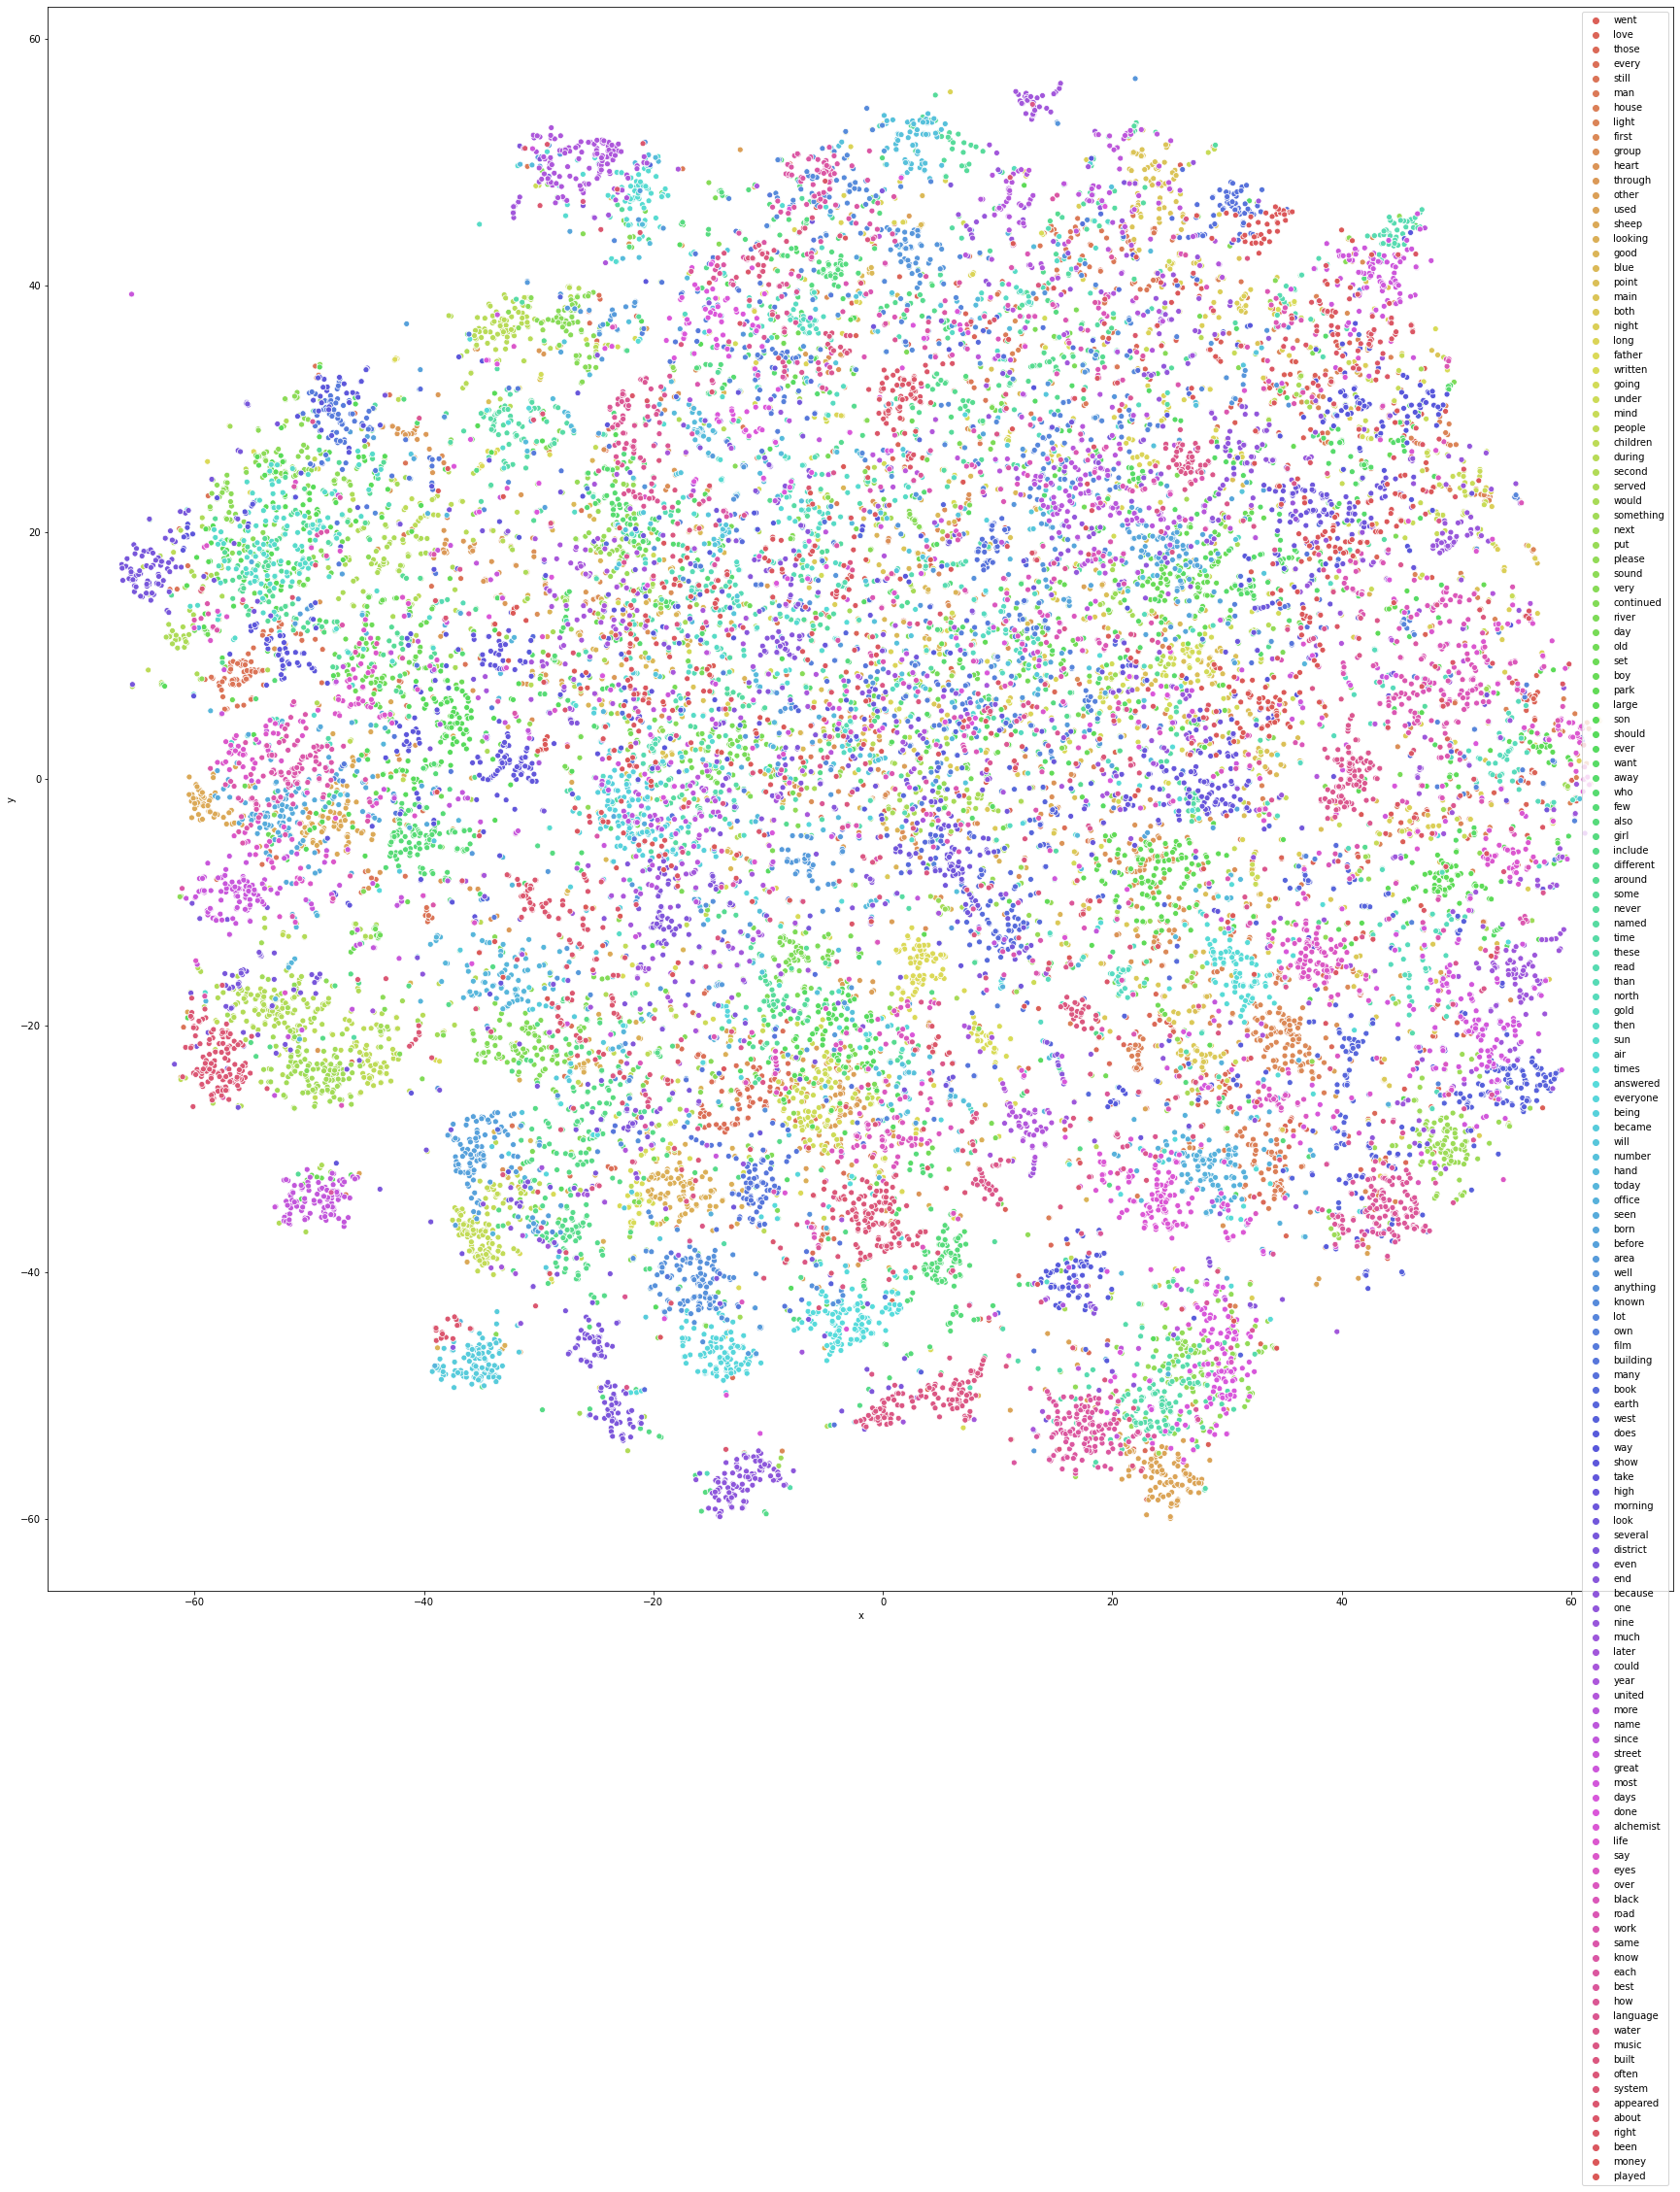

In [119]:
sns.scatterplot(x="x", 
                y="y", 
                hue=df.keyword.tolist(), 
                data=df,
                palette=sns.color_palette("hls", len(good_embeddings.keys())) 
               );
plt.gcf().set_size_inches(30,30);

In [86]:
mydata = [[0,1, "hi"],[0,2, "hi"],[5,6,"bye"],[5,7,"bye"]]
df = pd.DataFrame(mydata, columns=["x", "y", "lbl"])
df

,x,y,lbl
0,0,1,hi
1,0,2,hi
2,5,6,bye
3,5,7,bye


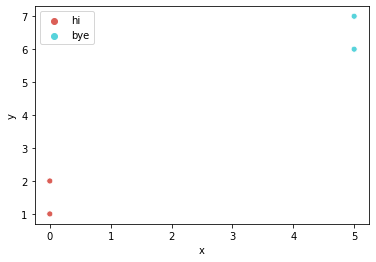

In [92]:
# https://stackoverflow.com/a/63640434
sns.scatterplot(x="x", y="y", hue=df.lbl.tolist(), data=df,palette=sns.color_palette("hls", 2), );